In [390]:
import os
from matplotlib import pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [391]:
train_data_path = './data/train'

In [392]:
test_data_path = './data/test'

In [393]:
mean = [0.4988, 0.5055, 0.4998]

In [394]:
std = [0.2169, 0.2055, 0.2387]

In [395]:
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
    
])

In [396]:
test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

In [397]:
train_dataset = torchvision.datasets.ImageFolder(root = train_data_path, transform = train_transforms)

In [398]:
test_dataset = torchvision.datasets.ImageFolder(root = test_data_path, transform = train_transforms)

In [224]:
def get_mean_and_std(loader):
    mean = 0
    std = 0
    total_images_count = 0
    for images, _ in loader:
        image_count_in_a_batch = images.size(0)
        images = images.view(image_count_in_a_batch, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += image_count_in_a_batch

    mean /= total_images_count
    std /= total_images_count


    return mean, std

In [280]:
#get_mean_and_std(train_loader)

In [399]:
def show_new_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size = 6, shuffle = True)
    batch = next(iter(loader))
    images, labels = batch

    grid = torchvision.utils.make_grid(images, nrow = 3)
    plt.figure(figsize=(11, 11))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    print('labels', labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4598541..2.3681598].


labels tensor([0, 1, 2, 7, 4, 7])


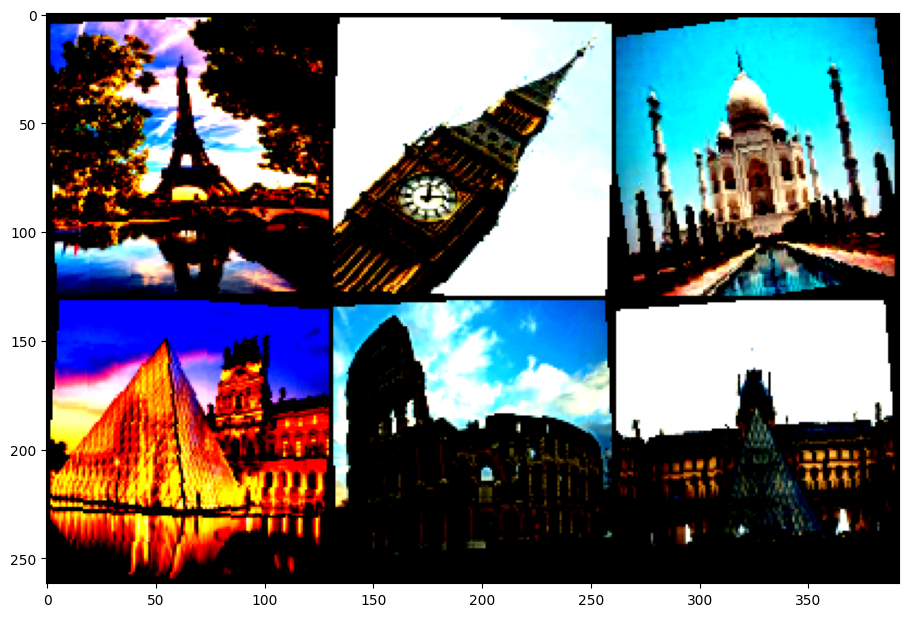

In [400]:
show_new_images(train_dataset)

In [401]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=16, shuffle=True)

In [402]:
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=16, shuffle=True)

In [403]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [404]:
image, _ = train_dataset[0]

In [405]:
class_names = ["Eiffel Tower_1", "Taj-Mahal_2", "machu picchu_3", "Coliseum_4", 
               "Great Wall of China_5", "Acropolis of Athens_6", "Louvre_7", 
               "Moscow Kremlin_8", "Milan Cathedral_9", "big ben_10"]

In [406]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_drop = nn.Dropout2d(p=0.4)
        
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 * 2, kernel_size=3, padding=1)
        self.conv2_drop = nn.Dropout2d(p=0.4)
        
        self.conv3 = nn.Conv2d(n_chans1 * 2, n_chans1 * 4, kernel_size=3, padding=1)
        self.conv3_drop = nn.Dropout2d(p=0.4)
        
        self.fc1 = nn.Linear(((n_chans1 * 4) * 16 * 16), 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_drop(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_drop(out)
        out = F.max_pool2d(torch.tanh(self.conv3(out)), 2)
        out = self.conv3_drop(out)

        out = out.view(-1,  ((self.n_chans1 * 4) * 16 * 16))
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [223]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [407]:
model = NetDropout()
#model(image.unsqueeze(0))

In [408]:
from torchsummary import summary
summary(model, input_size = (3, 128, 128));

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─Dropout2d: 1-2                         --
├─Conv2d: 1-3                            18,496
├─Dropout2d: 1-4                         --
├─Conv2d: 1-5                            73,856
├─Dropout2d: 1-6                         --
├─Linear: 1-7                            4,194,432
├─Linear: 1-8                            1,290
Total params: 4,288,970
Trainable params: 4,288,970
Non-trainable params: 0


In [409]:
print(model)

NetDropout(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_drop): Dropout2d(p=0.4, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_drop): Dropout2d(p=0.4, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_drop): Dropout2d(p=0.4, inplace=False)
  (fc1): Linear(in_features=32768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [410]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(4288970, [864, 32, 18432, 64, 73728, 128, 4194304, 128, 1280, 10])

In [411]:
import datetime

In [412]:
'''
def training_loop(n_epochs, optimizer, model, loss_function, train_loader):
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            #imgs = imgs.to(device=device)
            #labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_function(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print("{} Epoch{}, Training Loss {}".format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))
'''

#L2 - regularization
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            #imgs = imgs.to(device=device)
            #labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_function(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))

In [418]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=16, shuffle=False)

In [415]:
model = NetWidth()

In [416]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)

In [417]:
training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_function = loss_function,
    train_loader = train_loader)

2025-05-26 21:52:27.278362 Epoch1, Training Loss 2.2923012489968158
2025-05-26 21:55:10.478762 Epoch10, Training Loss 1.5687831259788352
2025-05-26 21:58:13.540989 Epoch20, Training Loss 0.9122725351059691
2025-05-26 22:01:26.110854 Epoch30, Training Loss 0.42103900617741524
2025-05-26 22:04:42.487465 Epoch40, Training Loss 0.13708311144975907
2025-05-26 22:07:48.223576 Epoch50, Training Loss 0.01589463094120568
2025-05-26 22:10:55.712999 Epoch60, Training Loss 0.0037245531002941365
2025-05-26 22:14:02.832406 Epoch70, Training Loss 0.002762181489936453
2025-05-26 22:17:08.603423 Epoch80, Training Loss 0.0010666529922944276
2025-05-26 22:20:18.270020 Epoch90, Training Loss 0.0008346930182132711
2025-05-26 22:23:26.049663 Epoch100, Training Loss 0.0007739138525992414


In [419]:
val_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=16, shuffle=False)

In [420]:
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                #imgs = imgs.to(device=device)
                #labels = labels.to(device=device)
                outputs= model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.2f}".format(name , correct / total))

In [421]:
validate(model, train_loader, val_loader)

Accuracy train: 1.00
Accuracy val: 0.61


In [422]:
torch.save(model.state_dict(), train_data_path + "landmarks.pt")

In [423]:
loaded_model = NetDropout()
loaded_model.load_state_dict(torch.load(train_data_path + "landmarks.pt"))

<All keys matched successfully>

In [424]:
#Example with new images
from PIL import Image

In [425]:
pic_1_path = 'example_1.jpg'
pic_2_path = 'example_2.jpeg'

In [426]:
image_1 = Image.open(pic_1_path)
image_2 = Image.open(pic_2_path)

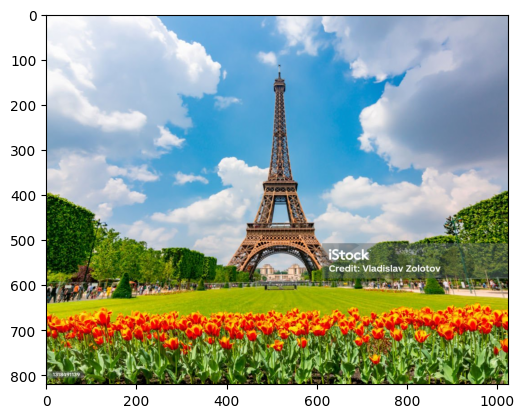

In [427]:
pic_1_plot = plt.imshow(image_1)

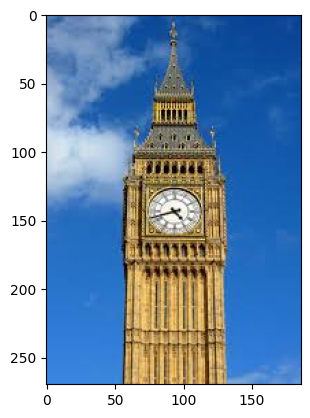

In [428]:
pic_2_plot = plt.imshow(image_2)

In [429]:
new_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(.5),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

In [430]:
transform_pic_1 = new_transform(image_1)
transform_pic_2 = new_transform(image_2)

In [431]:
def show_transform_images(tensor, title=None):
    image = tensor.numpy().transpose((1, 2, 0))
    mean = np.array([0.4988, 0.5055, 0.4998])
    std = np.array([0.2169, 0.2055, 0.2387])
    image = std * image + mean
    image = np.clip(image, 0, 1)

    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(.001)

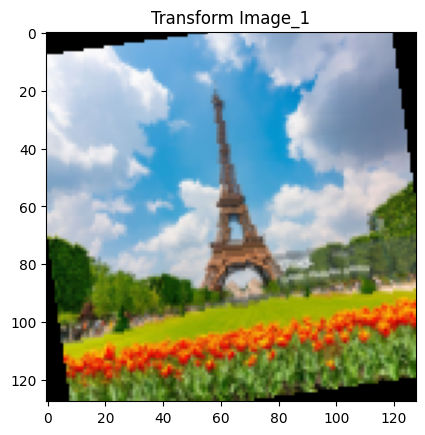

In [432]:
show_transform_images(transform_pic_1, title="Transform Image_1")

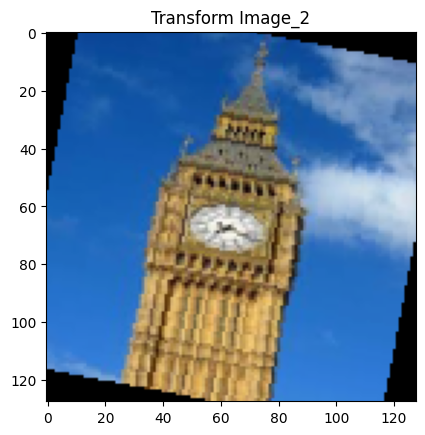

In [433]:
show_transform_images(transform_pic_2, title="Transform Image_2")

In [434]:
def load_image(image_path):
    image = Image.open(image_path)
    image = new_transform(image)
    image = image.unsqueeze(0)
    return image

In [435]:
image_path = ["example_1.jpg", "example_2.jpeg"]

In [436]:
images = [load_image(img) for img in image_path]

In [437]:
model.eval()

NetWidth(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=32768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [438]:
with torch.no_grad():
    for image in images:
        #image = image.to(device=device)
        output = model(image)
        _, predicted = torch.max(output, 1)
        print(f"Prediction: {class_names[predicted.item()]}")

Prediction: Milan Cathedral_9
Prediction: Taj-Mahal_2
